In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.7.1


# Set up the data

In [2]:
# Utility for loading up the dataset

def load_adult_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    y = y.to_frame()
    for col in X.columns:
      X[col] = X[col].astype('float32')

    for col in y.columns:
      y[col] = y[col].astype('float32')

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    return X, y

class PandasDataSet(TensorDataset):
    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()

In [3]:
# load adult data set
path = 'adult.data'
# path = 'adult.data'
X, y = load_adult_data(path)

n_features = X.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print(X_train.head())

features X: 30940 samples, 95 attributes
targets y: (30940, 1) samples
        age  education_num  capital_gain  capital_loss  hours_per_week  \
27719  17.0            7.0           0.0           0.0            12.0   
936    47.0           14.0           0.0           0.0            25.0   
3936   46.0           11.0           0.0           0.0            38.0   
8500   45.0           14.0           0.0        1902.0            50.0   
3882   51.0           10.0           0.0           0.0            40.0   

       workclass_Local-gov  workclass_Never-worked  workclass_Private  \
27719                  0.0                     0.0                1.0   
936                    0.0                     0.0                1.0   
3936                   0.0                     0.0                0.0   
8500                   0.0                     0.0                1.0   
3882                   0.0                     0.0                1.0   

       workclass_Self-emp-inc  workclass_Self

In [4]:
# Set up training & testing data
BATCH_SIZE = 100

train_data = PandasDataSet(X_train, y_train)
test_data = PandasDataSet(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print('# training samples:', len(train_data))
print('# testing samples:', len(test_data))
print('# batches:', len(train_loader))

print('# training samples:', len(test_data))
print('# batches:', len(test_loader))

# training samples: 24752
# testing samples: 6188
# batches: 247
# training samples: 6188
# batches: 61


# Define accuracy & Model

In [5]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(output - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(test_data)
    
    return acc

In [6]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# The calculation for immediate sensitivity

In [7]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    inp = inp.to(torch.cuda.current_device())
    outputs = model.forward(inp)
    labels = labels.to(torch.cuda.current_device())
    loss = criterion(outputs, labels)
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).cpu().numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

# Train the model, calculating immediate sensitivities

In [8]:
def run_experiment(epsilon):
    # reset the model
    torch.manual_seed(1)
    np.random.seed(7)
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(1))

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        mean_sensitivities.append(np.mean(all_sensitivities))
        print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        max_sigmas.append(np.max(sigmas))
        print("Max sigma for the epoch:", max_sigmas[-1])
        mean_sigmas.append(np.mean(sigmas))
        print("Mean sigma for the epoch:", mean_sigmas[-1])
        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)

In [9]:
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]

experiment_results = [run_experiment(epsilon)[0] for epsilon in epsilons]


NameError: name 'yappi' is not defined

In [10]:
def run_experiment_wo_sensitivity(epsilon):
    # reset the model
    torch.manual_seed(1)
    np.random.seed(7)
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            inp = Variable(x_batch_train, requires_grad=True)
    
            outputs = model.forward(inp)
            loss = model_criterion(outputs, y_batch_train)
            loss.backward()
            #loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            #batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            #all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            #sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            #sigmas.append(sigma)

            #with torch.no_grad():
                #for p in model.parameters():
                    #p.grad += (sigma * torch.randn(1))

            model_optimizer.step()

        #max_sensitivities.append(np.max(all_sensitivities))
        #print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        #mean_sensitivities.append(np.mean(all_sensitivities))
        #print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        #max_sigmas.append(np.max(sigmas))
        #print("Max sigma for the epoch:", max_sigmas[-1])
        #mean_sigmas.append(np.mean(sigmas))
        #print("Mean sigma for the epoch:", mean_sigmas[-1])
        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)

In [ ]:
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]

experiment_results_wo_sensititivity = [run_experiment_wo_sensitivity(epsilon)[0] for epsilon in epsilons]


In [ ]:
plt.plot(epsilons, experiment_results)
plt.xlabel('epsilon')
plt.ylabel('accuracy');

In [ ]:
plt.plot(epsilons, experiment_results_wo_sensititivity)
plt.xlabel('epsilon')
plt.ylabel('accuracy');

In [ ]:
final_acc, info_tuple = run_experiment(0.1)

In [ ]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)
train_losses = info_tuple[0]

plt.plot(train_losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# MNIST

In [9]:
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import importlib

import immediate_sensitivity_primitives as isp
importlib.reload(isp)
import membership_inference as mi
importlib.reload(mi)


<module 'membership_inference' from '/home/ubuntu/csl/experiments/immediate_sensitivity/membership_inference.py'>

In [10]:
# The labeled data from the dataloaders don't one-hot encode the labels... so I'm making a helper function to do it.
def one_hot_label(label,num_classes=10):
    zeros = [0]*num_classes
    zeros[label] = 1
    return torch.tensor(zeros)

In [11]:
def mnist_accuracy(model, test_loader, lf=nn.NLLLoss()):
    correct = 0
    num_data = 0
    lossies = []

    #grab a batch from the test loader
    for examples, labels in test_loader:
        examples = examples.to(torch.device("cuda:0"))
        gpu_lab = labels.to(torch.device('cuda:0'))
        outputs = model.forward(examples)
        lossies.append(lf(torch.squeeze(outputs), torch.squeeze(gpu_lab)))
        
        #for each output in the batch, check if the label is correct
        for i, output in enumerate(outputs):
            num_data += 1
            output = output.cpu()
            max_i = np.argmax(output.detach().numpy())
            if max_i == labels[i]:
                correct += 1

    acc = float(correct)/num_data
    loss = sum(lossies)/len(lossies)
    
    return acc, loss

In [12]:
BATCH_SIZE = 16

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor()) #target_transform=one_hot_label)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor()) #target_transform=one_hot_label)

mnist_train_sub = torch.utils.data.Subset(mnist_trainset, np.arange(0, 15000))
mnist_test_sub = torch.utils.data.Subset(mnist_testset, np.arange(0, 2500))
#mnist_trainset.targets = one_hot_labels(mnist_trainset.targets,10)
#mnist_testset.targets = one_hot_labels(mnist_testset.targets,10)
print(len(mnist_train_sub))
print(len(mnist_test_sub))
train_loader = DataLoader(mnist_train_sub, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test_sub, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# next(iter(train_loader))[0].shape --> torch.Size([16, 1, 28, 28])
# This means we have 16 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one).

15000
2500


In [14]:
next(iter(test_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [15]:
torch.cuda.get_device_name()

'Tesla T4'

In [16]:
class mnist_Classifier(nn.Module):
    def __init__(self):
        super(mnist_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3))
        self.mp1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.mp2 = nn.MaxPool2d(kernel_size=(2,2))
        self.fc1 = nn.Linear(64*4*4, 10)
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        # print(x.size()) --> torch.Size([16, 32, 20, 20])
        x = self.mp1(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.mp2(x)
        x = x.view(-1, 64*4*4)
        x = self.fc1(x)
        return torch.log_softmax(x,dim=1)

In [17]:
def run_mnist(epsilon):
    # reset the model
    model = mnist_Classifier()
    model.to(torch.device("cuda:0"))
    model_criterion = nn.NLLLoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 20
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    inference_tups = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for batch_id, (x_batch_train, y_batch_train) in enumerate(train_loader):
            
            #zero out the gradients from the previous iteration
            model_optimizer.zero_grad()
            
            #compute loss and sensitivities
            loss, batch_sensitivities = isp.grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            
            train_losses.append(loss.item())
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)
            
            '''
            # modify the gradients
            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(1))
            '''

            # perform the backpropagation
            model_optimizer.step()
        inference_tups.append(mi.merlin_optimal_thresh(model, train_loader, test_loader, lf=nn.CrossEntropyLoss, num_batches=20))
        inference_tups.append(mi.merlin_optimal_thresh(model, train_loader, test_loader, lf=nn.NLLLoss, num_batches=20))
        print(inference_tups[-1], inference_tups[-2])
        #max_sensitivities.append(np.max(all_sensitivities))
        #print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        #mean_sensitivities.append(np.mean(all_sensitivities))
        #print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        #max_sigmas.append(np.max(sigmas))
        #print("Max sigma for the epoch:", max_sigmas[-1])
        #mean_sigmas.append(np.mean(sigmas))
        #print("Mean sigma for the epoch:", mean_sigmas[-1])
        print("Average train loss:", np.mean(train_losses))
        test_accs.append(mnist_accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return model, mnist_accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups)

In [39]:
# try again with gpu
model, final_acc, info_tuple = run_mnist(0.1)

Start of epoch 0
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
tor

KeyboardInterrupt: 

In [12]:
import membership_inference as mi
importlib.reload(mi)

<module 'membership_inference' from '/home/ubuntu/csl/experiments/immediate_sensitivity/membership_inference.py'>

In [139]:
mi.merlin_optimal_thresh(model, train_loader, test_loader, lf=nn.NLLLoss)

(0.022733333333333328, 56)

In [13]:
import matplotlib.pyplot as plt
train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups = info_tuple
nll_infer = [i for k, i in enumerate(inference_tups) if k % 2 != 0]
cross_infer = [i for k, i in enumerate(inference_tups) if k % 2 == 0]

NameError: name 'info_tuple' is not defined

In [141]:
nll_adv, nll_thresh = [i[0] for i in nll_infer], [i[1] for i in nll_infer]
cross_adv, cross_thresh = [i[0] for i in cross_infer], [i[1] for i in cross_infer]

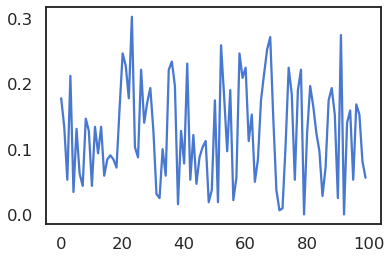

In [142]:
plt.plot(nll_adv)

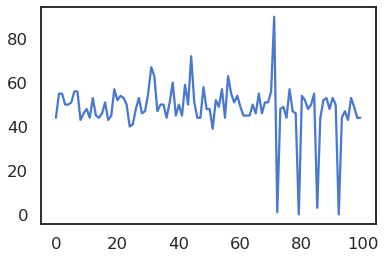

In [143]:
plt.plot(nll_thresh)

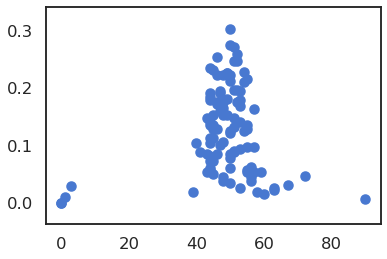

In [147]:
plt.scatter(nll_thresh, nll_adv)

In [155]:
model2, final_acc2, info_tuple2 = run_mnist(0.1)

Start of epoch 0
(0.07187500000000002, 49)
Average train loss: 0.24609022924409168
Accuracy: 0.9595352564102564
Start of epoch 1
(0.034375000000000044, 48)
Average train loss: 0.16054268965693202
Accuracy: 0.9671474358974359
Start of epoch 2
(0.171875, 49)
Average train loss: 0.12392478565266926
Accuracy: 0.9711538461538461
Start of epoch 3
(0.09687499999999999, 54)
Average train loss: 0.10203636088368599
Accuracy: 0.9731570512820513
Start of epoch 4
(0.018749999999999996, 59)
Average train loss: 0.08756689182062088
Accuracy: 0.9803685897435898
Start of epoch 5
(0, 0)
Average train loss: 0.07682169701635894
Accuracy: 0.9735576923076923
Start of epoch 6
(0.046875, 45)
Average train loss: 0.06906913917108531
Accuracy: 0.9763621794871795
Start of epoch 7
(0.012499999999999997, 53)
Average train loss: 0.0621305222240621
Accuracy: 0.9767628205128205
Start of epoch 8
(0.03749999999999998, 18)
Average train loss: 0.05685766385196307
Accuracy: 0.9763621794871795
Start of epoch 9
(0.00937500000

## Texas

In [24]:
import pickle
BATCH_SIZE = 64

In [25]:
features = pickle.load(open("../../data/texas_100_features.p", 'rb')).astype(np.float32)
labels = pickle.load(open("../../data/texas_100_labels.p", 'rb'))

In [26]:
ds = list(zip(features, labels))
len(ds)

67330

In [27]:
features.dtype

dtype('float32')

In [28]:
texas_train = ds[:60000]
texas_test = ds[60000:]
test_inputs, test_labels = zip(*texas_test)
test_labels[0]

24

In [29]:
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels,dtype=torch.long)

In [30]:
tx_train_loader = DataLoader(texas_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tx_test_loader = DataLoader(texas_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [31]:
class texas_Classifier(nn.Module):
    def __init__(self):
        super(texas_Classifier, self).__init__()
        self.fc1 = nn.Linear(6169, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return torch.log_softmax(x,dim=1)

In [32]:
def run_texas(epsilon, noise=False):
    # reset the model
    model = texas_Classifier()
    model.to(torch.device("cuda:0"))
    model_criterion = nn.NLLLoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 20
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    inference_tups = []
    yeom_adv = []
    test_losses = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for batch_id, (x_batch_train, y_batch_train) in enumerate(tx_train_loader):
            
            #zero out the gradients from the previous iteration
            model_optimizer.zero_grad()
            
            #compute loss and sensitivities
            loss, batch_sensitivities = isp.grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            
            train_losses.append(loss.item())
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)
            
            if noise:
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad += (sigma * torch.randn(1, device=torch.cuda.current_device()))
            

            # perform the backpropagation
            model_optimizer.step()
        inference_tups.append(mi.merlin_optimal_thresh(model, tx_train_loader, tx_test_loader, lf=nn.NLLLoss, num_batches=20))

        print(inference_tups[-1])
        max_sensitivities.append(np.max(all_sensitivities))
        print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        mean_sensitivities.append(np.mean(all_sensitivities))
        print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        max_sigmas.append(np.max(sigmas))
        print("Max sigma for the epoch:", max_sigmas[-1])
        mean_sigmas.append(np.mean(sigmas))
        print("Mean sigma for the epoch:", mean_sigmas[-1])
        ti =  np.mean(train_losses)
        print("Average train loss:",ti)
        yeom_train = mi.run_yeom_loader(model, ti, tx_train_loader, lf=nn.NLLLoss, num_batches=20)
        yeom_test = mi.run_yeom_loader(model, ti, tx_test_loader, lf=nn.NLLLoss, num_batches=20)
        yeom_adv.append((yeom_train, yeom_test))
        print("yeom adv: ", yeom_train, yeom_test)
        ta, tl = mnist_accuracy(model, tx_test_loader)
        test_accs.append(ta)
        test_losses.append(tl)
        print("Accuracy:", test_accs[-1])
    return model, mnist_accuracy(model, tx_test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups, test_losses, yeom_adv)

In [37]:
model, accuracy, info_tuple = run_texas(.01)

Start of epoch 0
(0.021875000000000006, 96)
Max batch sensitivity for the epoch: 3.5946693420410156
Mean batch sensitivity for the epoch: 0.7150532873551866
Max sigma for the epoch: 643.0340004350522
Mean sigma for the epoch: 127.91262064487104
Average train loss: 1.9701682859659195
yeom adv:  0.8125 0.74375
Accuracy: 0.5828329694323144
Start of epoch 1
(0.03437499999999999, 98)
Max batch sensitivity for the epoch: 5.746617317199707
Mean batch sensitivity for the epoch: 1.2879129803737004
Max sigma for the epoch: 1027.9861569548814
Mean sigma for the epoch: 230.38887785759573
Average train loss: 1.5770401222467423
yeom adv:  0.796875 0.721875
Accuracy: 0.630867903930131
Start of epoch 2
(0.05625000000000002, 86)
Max batch sensitivity for the epoch: 11.158712387084961
Mean batch sensitivity for the epoch: 1.873332386358579
Max sigma for the epoch: 1996.1311551112735
Mean sigma for the epoch: 335.11188482797456
Average train loss: 1.3707211134764883
yeom adv:  0.821875 0.7125
Accuracy: 0

In [91]:
train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups, test_losses, yeom_adv = info_tuple

In [92]:
epoch_breaks = np.linspace(0, len(train_losses), 20,dtype=np.int32)
print(epoch_breaks)
train_l_per_epoch = []
for i in range(1,len(epoch_breaks)):
    train_l_per_epoch.append(np.mean(train_losses[epoch_breaks[i-1]:epoch_breaks[i]]))


[    0  3947  7894 11842 15789 19736 23684 27631 31578 35526 39473 43421
 47368 51315 55263 59210 63157 67105 71052 75000]


Text(0.5, 1.0, 'no noise')

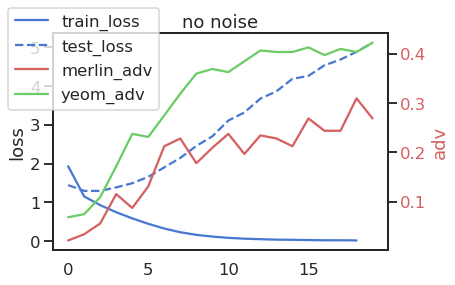

In [93]:
adv, thresh = zip(*inference_tups)
ya  = [a - b for a, b in yeom_adv]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(train_l_per_epoch, label="train_loss")
ax1.plot(test_losses, 'b--', label='test_loss')
ax1.set_ylabel('loss')

ax2 = ax1.twinx()
ax2.plot(adv, 'r-', label='merlin_adv')
ax2.plot(ya, 'g-', label='yeom_adv')
ax2.set_ylabel('adv', color='r')
fig.legend(loc='upper left')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_title("no noise")

In [68]:
model3, accuracy3, info_tuple3 = run_texas(10000, noise=True)

Start of epoch 0
(0.05937500000000001, 99)
Max batch sensitivity for the epoch: 1.794937014579773
Mean batch sensitivity for the epoch: 0.24132614278130737
Max sigma for the epoch: 0.3210880943944723
Mean sigma for the epoch: 0.043169732800545875
Average train loss: 3.601403438218435
yeom adv:  0.625 0.596875
Accuracy: 0.24713427947598254
Start of epoch 1
(0.009375000000000022, 51)
Max batch sensitivity for the epoch: 5.30671501159668
Mean batch sensitivity for the epoch: 1.0854001646200815
Max sigma for the epoch: 0.9492940402519008
Mean sigma for the epoch: 0.1941622840703972
Average train loss: 3.3617009852409363
yeom adv:  0.546875 0.584375
Accuracy: 0.2671943231441048
Start of epoch 2
(0.06562500000000004, 96)
Max batch sensitivity for the epoch: 3.3911421298980713
Mean batch sensitivity for the epoch: 1.061013967080911
Max sigma for the epoch: 0.6066259459052408
Mean sigma for the epoch: 0.18979994843757128
Average train loss: 3.232380727322896
yeom adv:  0.609375 0.559375
Accura

[    0  3947  7894 11842 15789 19736 23684 27631 31578 35526 39473 43421
 47368 51315 55263 59210 63157 67105 71052 75000]


Text(0.5, 1.0, 'epsilon=10000')

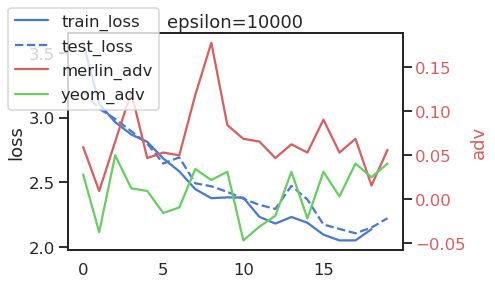

In [87]:
train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups, test_losses, yeom_adv = info_tuple3
epoch_breaks = np.linspace(0, len(train_losses), 20,dtype=np.int32)
print(epoch_breaks)
train_l_per_epoch = []
for i in range(1,len(epoch_breaks)):
    train_l_per_epoch.append(np.mean(train_losses[epoch_breaks[i-1]:epoch_breaks[i]]))
    
adv, thresh = zip(*inference_tups)
ya  = [a - b for a, b in yeom_adv]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(train_l_per_epoch, label="train_loss")
ax1.plot(test_losses, 'b--', label='test_loss')
ax1.set_ylabel('loss')

ax2 = ax1.twinx()
ax2.plot(adv, 'r-', label='merlin_adv')
ax2.plot(ya, 'g-', label='yeom_adv')
ax2.set_ylabel('adv', color='r')
fig.legend(loc='upper left')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_title('epsilon=10000')

In [33]:
model4, accuracy4, info_tuple4 = run_texas(10000, noise=True)

Start of epoch 0
(0.05703125000000003, 98)
Max batch sensitivity for the epoch: 0.04454529657959938
Mean batch sensitivity for the epoch: 0.011532785006655933
Max sigma for the epoch: 0.015937009796779693
Mean sigma for the epoch: 0.004126094599163684
Average train loss: 3.297485504486263
yeom adv:  0.65546875 0.59296875
Accuracy: 0.31620065789473684
Start of epoch 1
(0.09218749999999998, 99)
Max batch sensitivity for the epoch: 2.19823956489563
Mean batch sensitivity for the epoch: 0.12246518929935236
Max sigma for the epoch: 0.7864660956697902
Mean sigma for the epoch: 0.04381447810411709
Average train loss: 2.926714339976377
yeom adv:  0.5328125 0.48984375
Accuracy: 0.2490405701754386
Start of epoch 2
(0.0234375, 63)
Max batch sensitivity for the epoch: 4.652345657348633
Mean batch sensitivity for the epoch: 0.9003962624416535
Max sigma for the epoch: 1.664473783145198
Mean sigma for the epoch: 0.32213555992100446
Average train loss: 2.8616079906262097
yeom adv:  0.6359375 0.5992187

In [34]:
model5, accuracy5, info_tuple5 = run_texas(50000, noise=True)

Start of epoch 0
(0.026562499999999933, 58)
Max batch sensitivity for the epoch: 0.04220805689692497
Mean batch sensitivity for the epoch: 0.011777554626674971
Max sigma for the epoch: 0.006753289103507996
Mean sigma for the epoch: 0.0018844087402679957
Average train loss: 2.950293879244345
yeom adv:  0.70546875 0.6703125
Accuracy: 0.42859100877192985
Start of epoch 1
(0.004687500000000067, 37)
Max batch sensitivity for the epoch: 0.10963355004787445
Mean batch sensitivity for the epoch: 0.037499613684215435
Max sigma for the epoch: 0.017541368007659913
Mean sigma for the epoch: 0.00599993818947447
Average train loss: 2.4191710572995904
yeom adv:  0.7265625 0.67734375
Accuracy: 0.49890350877192985
Start of epoch 2
(0.03359374999999998, 53)
Max batch sensitivity for the epoch: 0.22663654386997223
Mean batch sensitivity for the epoch: 0.05848299008530734
Max sigma for the epoch: 0.036261847019195555
Mean sigma for the epoch: 0.009357278413649174
Average train loss: 2.190241872225313
yeom

[    0   986  1972  2958  3945  4931  5917  6904  7890  8876  9863 10849
 11835 12822 13808 14794 15781 16767 17753 18740]


Text(0.5, 1.0, 'epsilon=50000')

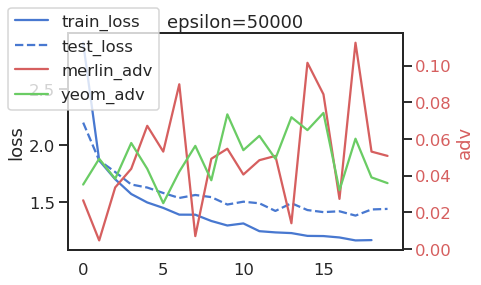

In [36]:
train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, inference_tups, test_losses, yeom_adv = info_tuple5
epoch_breaks = np.linspace(0, len(train_losses), 20,dtype=np.int32)
print(epoch_breaks)
train_l_per_epoch = []
for i in range(1,len(epoch_breaks)):
    train_l_per_epoch.append(np.mean(train_losses[epoch_breaks[i-1]:epoch_breaks[i]]))
    
adv, thresh = zip(*inference_tups)
ya  = [a - b for a, b in yeom_adv]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(train_l_per_epoch, label="train_loss")
ax1.plot(test_losses, 'b--', label='test_loss')
ax1.set_ylabel('loss')

ax2 = ax1.twinx()
ax2.plot(adv, 'r-', label='merlin_adv')
ax2.plot(ya, 'g-', label='yeom_adv')
ax2.set_ylabel('adv', color='r')
fig.legend(loc='upper left')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.set_title('epsilon=50000')